# library

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import tensorflow as tf
import splitfolders
import random
import shutil
import scipy
import torch

from numpy import size
import seaborn as sns
from pathlib import Path
from PIL import Image
from keras.preprocessing.image import ImageDataGenerator
from keras import applications
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Input, Convolution2D, MaxPool2D, Flatten
from keras.models import Model
from keras.layers import Input
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils import compute_class_weight

from tensorflow.keras.callbacks import TensorBoard
from datetime import datetime
from keras.utils import plot_model

# code

In [2]:
## access dataset
main_dataset = Path ('D:/UNCC/Fall_23/ECGR_8119/hw_1/dogs_vs_cats/') 
    
data_path = Path('D:/UNCC/Fall_23/ECGR_8119/hw_1/dogs_vs_cats/train1') ## data directory containing 25000 images

# data splitting (subdirectory present)

In [34]:
# input_folder = data_path
# output_folder = Path ('D:/UNCC/Fall_23/ECGR_8119/hw_1/dogs_vs_cats/splitdata')
# splitfolders.ratio (input_folder, output_folder, seed =1337, ratio = (.7,.2,.1))


Copying files: 0 files [00:00, ? files/s]
Copying files: 1 files [00:00,  3.20 files/s]
Copying files: 211 files [00:00, 657.94 files/s]
Copying files: 424 files [00:00, 1111.89 files/s]
Copying files: 638 files [00:00, 1423.98 files/s]
Copying files: 881 files [00:00, 1682.49 files/s]
Copying files: 1095 files [00:00, 1813.84 files/s]
Copying files: 1314 files [00:00, 1923.75 files/s]
Copying files: 1540 files [00:01, 2016.77 files/s]
Copying files: 1756 files [00:01, 2057.39 files/s]
Copying files: 1980 files [00:01, 2109.11 files/s]
Copying files: 2197 files [00:01, 2121.84 files/s]
Copying files: 2415 files [00:01, 2135.58 files/s]
Copying files: 2633 files [00:01, 2143.88 files/s]
Copying files: 2850 files [00:01, 2150.61 files/s]
Copying files: 3084 files [00:01, 2143.35 files/s]
Copying files: 3300 files [00:01, 2148.03 files/s]
Copying files: 3516 files [00:01, 2151.33 files/s]
Copying files: 3732 files [00:02, 2151.75 files/s]
Copying files: 3959 files [00:02, 2181.00 files/s

In [68]:
# # Define the input folder
# input_folder = data_path

# # Define the output folder
# output_folder = Path ('D:/UNCC/Fall_23/ECGR_8119/hw_1/dogs_vs_cats/splitdata2')

# # Split the data into training and validation sets
# splitfolders.ratio(input_folder, output_folder, seed=1337, ratio=(.8, .2))

Copying files: 25000 files [00:29, 855.50 files/s] 


# initiating data generator

In [3]:
train_dir = Path ('D:/UNCC/Fall_23/ECGR_8119/hw_1/dogs_vs_cats/splitdata/train')# has 2 folders: cat, dog
val_dir   = Path ('D:/UNCC/Fall_23/ECGR_8119/hw_1/dogs_vs_cats/splitdata/val')#has 2 folders: cat, dog
test_dir = Path ('D:/UNCC/Fall_23/ECGR_8119/hw_1/dogs_vs_cats/splitdata/test')# same

#create a data generator from ImageDataGenerator which performs augmentation
#rescaling /255 to get pixel values between 0 and 1
#horizontal and vertical flip set to true
#rotation range set to 30 degrees
train_data_gen = ImageDataGenerator(
    
    rescale = 1./255,
    horizontal_flip = True,
    vertical_flip = True,
    rotation_range = 30,
    fill_mode = 'constant' )


#data generator to augment validation and test images. only rescaling is applied
val_test_data_gen = ImageDataGenerator(
    
    rescale = 1./255,
)




# test_data_generator= ImageDataGenerator(  
#     rescale = 1./255)


#create a training, validation and testing generator which generates a batch of images from the  data
#shuffle set to true to add variance only for training and validation set

train_gen = train_data_gen.flow_from_directory(
    directory= train_dir,
    target_size = (128, 128),
    class_mode = 'categorical',
    color_mode = 'rgb',
    batch_size = 50,
    shuffle = True)
#grab the number of samples
train_num = train_gen.samples


validate_gen = val_test_data_gen.flow_from_directory(
    directory= val_dir,
    target_size = (128, 128),
    class_mode = 'categorical',
    color_mode = 'rgb',
    batch_size = 50,
    shuffle = True)
#grab number of samples
validate_num = validate_gen.samples


test_gen = val_test_data_gen.flow_from_directory(
    directory= test_dir,
    target_size = (128, 128),
    class_mode = 'categorical',
    color_mode = 'rgb',
    batch_size = 50,
    shuffle = False)
#grab the number of samples
test_num = test_gen.samples




Found 17500 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.


In [ ]:
##install OpenCV
# !pip install opencv-python numpy

In [ ]:
### import libraries
# import cv2
# import random

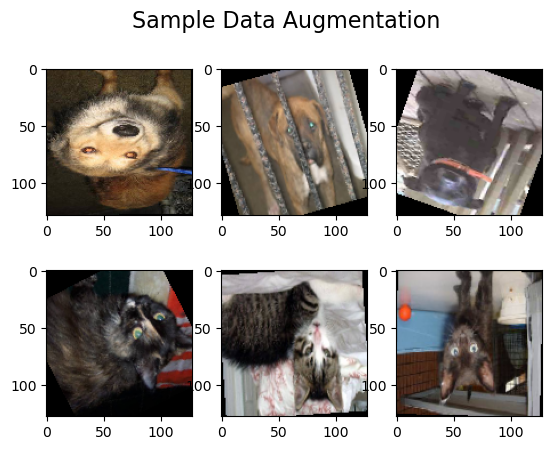

y Labels:  [[0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


In [4]:
#visualize the augmented data
# Get the next batch of images from the train generator
train_images, train_labels = train_gen.next()

#grab the first 8 in the batch and their labels and plot them
for k in range(1,7):
    sample_img = train_images[k,:,:,:]
    plt.subplot(2, 3, k)
    plt.imshow(sample_img)
plt.suptitle('Sample Data Augmentation', fontsize = 16)    
plt.show()

print('y Labels: ', train_labels[1:7])

In [5]:
# #train_images[0].shape

x = train_images[0].shape
# print (x)
# image_input = Input(x)
# image_input.shape


# initiating the model

In [6]:
# loading the resnet50 model for pretrained initialization
# weights set to imagenet


image_input = Input (x)
base_model = tf.keras.applications.resnet50.ResNet50(input_tensor = image_input,weights = 'imagenet', include_top=False)

#Freeze ResNet's layers so their paramteres dont get retrained
# for layer in base_model.layers[:-6]:
#     layer.trainable = False
base_output = base_model.layers[-1].output
flat1 = Flatten()(base_output)

fc1 = Dense(500, activation = 'relu')(flat1)
dropfc1 = Dropout(0.5)(fc1)
fc2 = Dense(100, activation = 'relu')(dropfc1)
dropfc2 = Dropout(0.5)(fc2)

predictions = Dense(2, activation = 'sigmoid')(dropfc2)


#creating new model
model = Model (inputs = base_model.input, outputs = predictions)

model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 134, 134, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 64, 64, 64)           9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 64, 64, 64)           256       ['conv1_conv[0][0]']          
 on)                                                                                          

                                                                                                  
 conv2_block3_1_conv (Conv2  (None, 32, 32, 64)           16448     ['conv2_block2_out[0][0]']    
 D)                                                                                               
                                                                                                  
 conv2_block3_1_bn (BatchNo  (None, 32, 32, 64)           256       ['conv2_block3_1_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv2_block3_1_relu (Activ  (None, 32, 32, 64)           0         ['conv2_block3_1_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv2_blo

 ation)                                                                                           
                                                                                                  
 conv3_block2_3_conv (Conv2  (None, 16, 16, 512)          66048     ['conv3_block2_2_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv3_block2_3_bn (BatchNo  (None, 16, 16, 512)          2048      ['conv3_block2_3_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv3_block2_add (Add)      (None, 16, 16, 512)          0         ['conv3_block1_out[0][0]',    
                                                                     'conv3_block2_3_bn[0][0]']   
          

 conv4_block1_2_conv (Conv2  (None, 8, 8, 256)            590080    ['conv4_block1_1_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv4_block1_2_bn (BatchNo  (None, 8, 8, 256)            1024      ['conv4_block1_2_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv4_block1_2_relu (Activ  (None, 8, 8, 256)            0         ['conv4_block1_2_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv4_block1_0_conv (Conv2  (None, 8, 8, 1024)           525312    ['conv3_block4_out[0][0]']    
 D)       

                                                                                                  
 conv4_block3_out (Activati  (None, 8, 8, 1024)           0         ['conv4_block3_add[0][0]']    
 on)                                                                                              
                                                                                                  
 conv4_block4_1_conv (Conv2  (None, 8, 8, 256)            262400    ['conv4_block3_out[0][0]']    
 D)                                                                                               
                                                                                                  
 conv4_block4_1_bn (BatchNo  (None, 8, 8, 256)            1024      ['conv4_block4_1_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv4_blo

 D)                                                                                               
                                                                                                  
 conv4_block6_3_bn (BatchNo  (None, 8, 8, 1024)           4096      ['conv4_block6_3_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv4_block6_add (Add)      (None, 8, 8, 1024)           0         ['conv4_block5_out[0][0]',    
                                                                     'conv4_block6_3_bn[0][0]']   
                                                                                                  
 conv4_block6_out (Activati  (None, 8, 8, 1024)           0         ['conv4_block6_add[0][0]']    
 on)                                                                                              
          

 conv5_block3_1_relu (Activ  (None, 4, 4, 512)            0         ['conv5_block3_1_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv5_block3_2_conv (Conv2  (None, 4, 4, 512)            2359808   ['conv5_block3_1_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv5_block3_2_bn (BatchNo  (None, 4, 4, 512)            2048      ['conv5_block3_2_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv5_block3_2_relu (Activ  (None, 4, 4, 512)            0         ['conv5_block3_2_bn[0][0]']   
 ation)   

# hyperparameters and checkpoints

In [7]:
from tensorflow.python.keras.utils.np_utils import to_categorical

opt = Adam (learning_rate = 1e-4 )
model.compile(optimizer= opt, loss = 'binary_crossentropy', metrics = ['accuracy'])

#early stopping to break training loop
# early_stop = EarlyStopping(monitor='val_loss', patience=3)

#checkpoints
# checkpoint = ModelCheckpoint('best_model.h5',
#                              monitor='val_loss',
#                              save_best_only=True,
#                              mode='min')


fold_num=1

# Folder setup
init_time = datetime.now()
current_time = init_time.strftime('%Y%m%d_%H%M%S')
name_dir = 'trained_models_' + current_time + '_fold_num' + str(fold_num)
os.mkdir(name_dir)

# Callbacks1: ModelCheckpointer
model_file_format = name_dir + '/model_' + str(fold_num) + '_model.{epoch:04d}.hdf5'
checkpoint = ModelCheckpoint(model_file_format, monitor ='val_loss', save_best_only = True, verbose = 1)

# Callbacks2: TensorBoard
tensor_check = './logs/' + current_time + '_train_testsplit' + str(fold_num)
tensor_board = TensorBoard(tensor_check)

# Callbacks3: EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=4, verbose=0, mode='auto')
# Plot model
figure_name = name_dir + '/model_output.png'
plot_model(model, figure_name, show_shapes = True)
#plt.show (model, figure_name, show_shapes = True)


# Display model


model.summary()

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 134, 134, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 64, 64, 64)           9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 64, 64, 

 on)                                                                                              
                                                                                                  
 conv2_block3_1_conv (Conv2  (None, 32, 32, 64)           16448     ['conv2_block2_out[0][0]']    
 D)                                                                                               
                                                                                                  
 conv2_block3_1_bn (BatchNo  (None, 32, 32, 64)           256       ['conv2_block3_1_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv2_block3_1_relu (Activ  (None, 32, 32, 64)           0         ['conv2_block3_1_bn[0][0]']   
 ation)                                                                                           
          

 conv3_block2_2_relu (Activ  (None, 16, 16, 128)          0         ['conv3_block2_2_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv3_block2_3_conv (Conv2  (None, 16, 16, 512)          66048     ['conv3_block2_2_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv3_block2_3_bn (BatchNo  (None, 16, 16, 512)          2048      ['conv3_block2_3_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv3_block2_add (Add)      (None, 16, 16, 512)          0         ['conv3_block1_out[0][0]',    
          

                                                                                                  
 conv4_block1_2_conv (Conv2  (None, 8, 8, 256)            590080    ['conv4_block1_1_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv4_block1_2_bn (BatchNo  (None, 8, 8, 256)            1024      ['conv4_block1_2_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv4_block1_2_relu (Activ  (None, 8, 8, 256)            0         ['conv4_block1_2_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv4_blo

                                                                     'conv4_block3_3_bn[0][0]']   
                                                                                                  
 conv4_block3_out (Activati  (None, 8, 8, 1024)           0         ['conv4_block3_add[0][0]']    
 on)                                                                                              
                                                                                                  
 conv4_block4_1_conv (Conv2  (None, 8, 8, 256)            262400    ['conv4_block3_out[0][0]']    
 D)                                                                                               
                                                                                                  
 conv4_block4_1_bn (BatchNo  (None, 8, 8, 256)            1024      ['conv4_block4_1_conv[0][0]'] 
 rmalization)                                                                                     
          

 conv4_block6_3_conv (Conv2  (None, 8, 8, 1024)           263168    ['conv4_block6_2_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv4_block6_3_bn (BatchNo  (None, 8, 8, 1024)           4096      ['conv4_block6_3_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv4_block6_add (Add)      (None, 8, 8, 1024)           0         ['conv4_block5_out[0][0]',    
                                                                     'conv4_block6_3_bn[0][0]']   
                                                                                                  
 conv4_block6_out (Activati  (None, 8, 8, 1024)           0         ['conv4_block6_add[0][0]']    
 on)      

                                                                                                  
 conv5_block3_1_relu (Activ  (None, 4, 4, 512)            0         ['conv5_block3_1_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv5_block3_2_conv (Conv2  (None, 4, 4, 512)            2359808   ['conv5_block3_1_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv5_block3_2_bn (BatchNo  (None, 4, 4, 512)            2048      ['conv5_block3_2_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv5_blo

# training

In [8]:
history = model.fit(
    train_gen,
#     epochs = 25,
    epochs =5, #best result
    steps_per_epoch = train_num // 50,
    validation_data = validate_gen,
    validation_steps = validate_num // 50,
#     callbacks=[early_stop, tensor_board],
    verbose =1,)

# early_stop_name = name_dir + '/fold_num_' + str(fold_num) + 'early_stop_model.hdf5'
# model.save_weights(early_stop_name)

Epoch 1/25
350/350 [==============================] - 925s 3s/step - loss: 0.3579 - accuracy: 0.8654 - val_loss: 1.5943 - val_accuracy: 0.4088
Epoch 2/25
350/350 [==============================] - 916s 3s/step - loss: 0.1715 - accuracy: 0.9351 - val_loss: 0.3967 - val_accuracy: 0.8268
Epoch 3/25
350/350 [==============================] - 898s 3s/step - loss: 0.1355 - accuracy: 0.9524 - val_loss: 0.1414 - val_accuracy: 0.9444
Epoch 4/25
350/350 [==============================] - 921s 3s/step - loss: 0.1157 - accuracy: 0.9563 - val_loss: 0.1437 - val_accuracy: 0.9508
Epoch 5/25
350/350 [==============================] - 912s 3s/step - loss: 0.0972 - accuracy: 0.9667 - val_loss: 0.1653 - val_accuracy: 0.9520
Epoch 6/25
350/350 [==============================] - 898s 3s/step - loss: 0.0903 - accuracy: 0.9680 - val_loss: 0.1056 - val_accuracy: 0.9632
Epoch 7/25
350/350 [==============================] - 883s 3s/step - loss: 0.0853 - accuracy: 0.9687 - val_loss: 0.1383 - val_accuracy: 0.9578

# testing

In [9]:
test_loss, test_accuracy = model.evaluate(test_gen, steps=len(test_gen), verbose=1)

print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')



50/50 [==============================] - 27s 530ms/step - loss: 0.1422 - accuracy: 0.9652
Test Loss: 0.1422
Test Accuracy: 0.9652


# confusion matrix

In [10]:
test_labels = test_gen.classes
print (test_labels)
print (len(test_labels))
print (train_gen.classes)
print (validate_gen.classes)


[0 0 0 ... 1 1 1]
2500
[0 0 0 ... 1 1 1]
[0 0 0 ... 1 1 1]


50/50 [==============================] - 26s 515ms/step


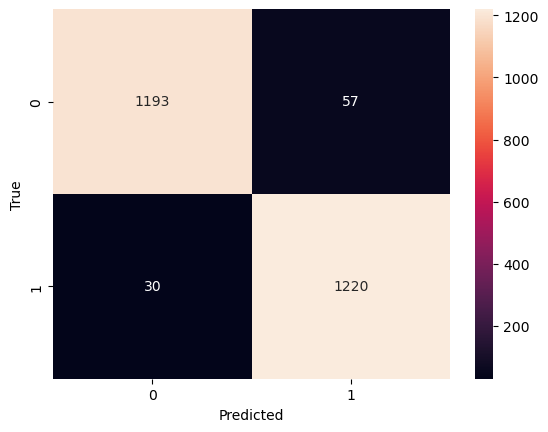

In [11]:
# Generate predictions on test data
test_predictions = model.predict(test_gen)
test_predictions = np.argmax(test_predictions, axis=1)
test_labels = test_gen.classes

# Plot the confusion matrix
cm = confusion_matrix(test_labels, test_predictions)

sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# plotting

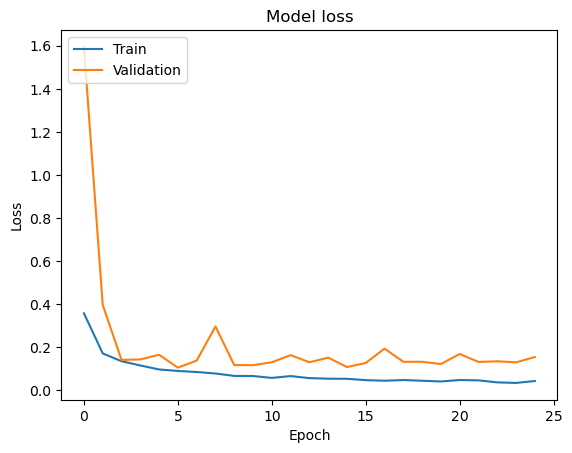

In [12]:
#plotting validation and training losses obtained from training
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [12]:
# !pip install split-folders
#!pip3 install pydot
#!pip install graphviz


#     SRGAN

In [2]:
import cv2
import numpy as np
np.random.seed(42)
import os
import matplotlib.pyplot as plt
import glob
import pandas as pd

import tensorflow as tf
# import tensorflow_datasets as tfds
from tensorflow.keras import layers

In [5]:
"""

Here, we are resizing them to 128x128 that will be  used as HR images and 
32x32 that will be used as LR images
"""

train_dir = Path ('D:/UNCC/Fall_23/ECGR_8119/hw_1/dogs_vs_cats/splitdata_midterm/train')
val_dir   = Path ('D:/UNCC/Fall_23/ECGR_8119/hw_1/dogs_vs_cats/splitdata_midterm/val')



# image downscaling to 32x32

In [9]:
# for class_name in ["cat", "dog"]:
#     hr_dir = str(train_dir) + "/hr_images_" + class_name
#     lr_dir = str(train_dir) + "/lr_images_" + class_name
#     os.makedirs(hr_dir, exist_ok=True)
#     os.makedirs(lr_dir, exist_ok=True)
#     for img in os.listdir(str(train_dir) + "/" + class_name):
        
#         img_array = cv2.imread(str(train_dir) + "/" + class_name + "/" + img)
#         img_array = cv2.resize(img_array, (128,128))
        
#         lr_img_array = cv2.resize(img_array,(32,32))
#         cv2.imwrite(hr_dir + "/" + img, img_array)
#         cv2.imwrite(lr_dir + "/" + img, lr_img_array)

# scaled image samples

[70, 77, 20]


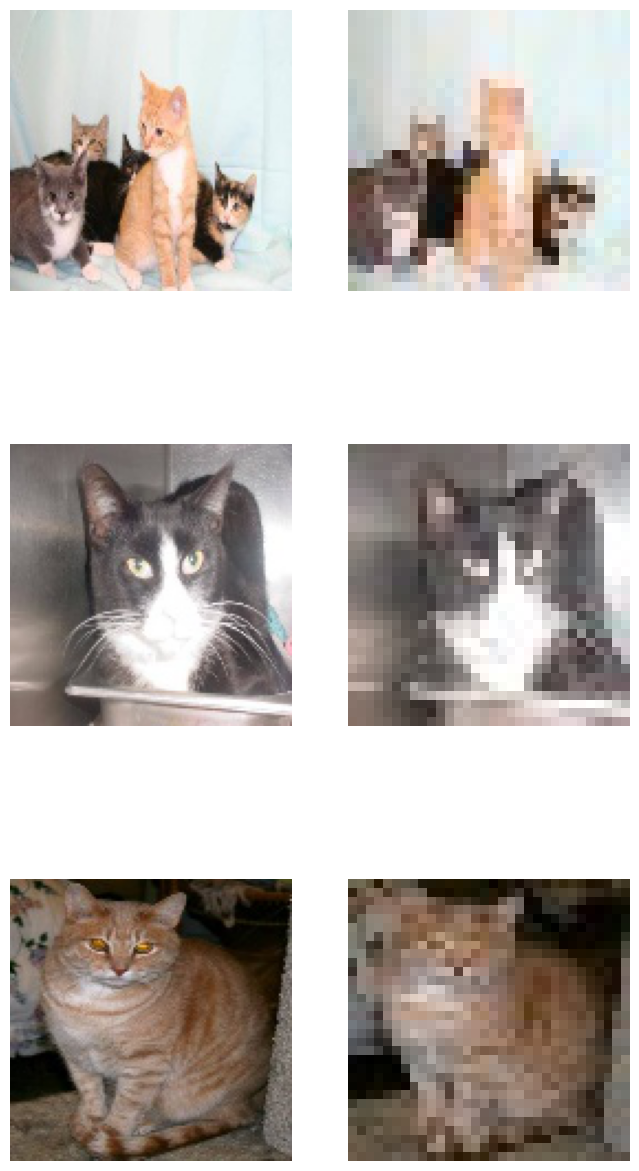

hr_img.shape: (128, 128, 3)
lr_img.shape: (32, 32, 3)


In [19]:
import matplotlib.pyplot as plt
import os

class_name = "cat"  # choose which class to visualize
hr_dir = str(train_dir) + "/hr_images_" + class_name
lr_dir = str(train_dir) + "/lr_images_" + class_name

# get a list of image file names
img_files = os.listdir(hr_dir)


# choose how many images to visualize
num_images = 3

#for random image selection
import random

# Generate three random integers
random_numbers = [random.randint(1, 100) for _ in range(num_images)]

# Print the generated random numbers
print(random_numbers)

j=0

# plot the images
fig, ax = plt.subplots(num_images, 2, figsize=(8, 16))
for i in random_numbers:
# for i in range(num_images):    
    # read the high-resolution image
    hr_img = plt.imread(os.path.join(hr_dir, img_files[i]))
    # read the low-resolution image
    lr_img = plt.imread(os.path.join(lr_dir, img_files[i]))
    # plot the images side by side
    
    ax[j, 0].imshow(hr_img)
    ax[j, 1].imshow(lr_img)
    ax[j, 0].axis("off")
    ax[j, 1].axis("off")
    j=j+1
plt.show()
print('hr_img.shape:', hr_img.shape)
print('lr_img.shape:', lr_img.shape)

[23, 86, 89]


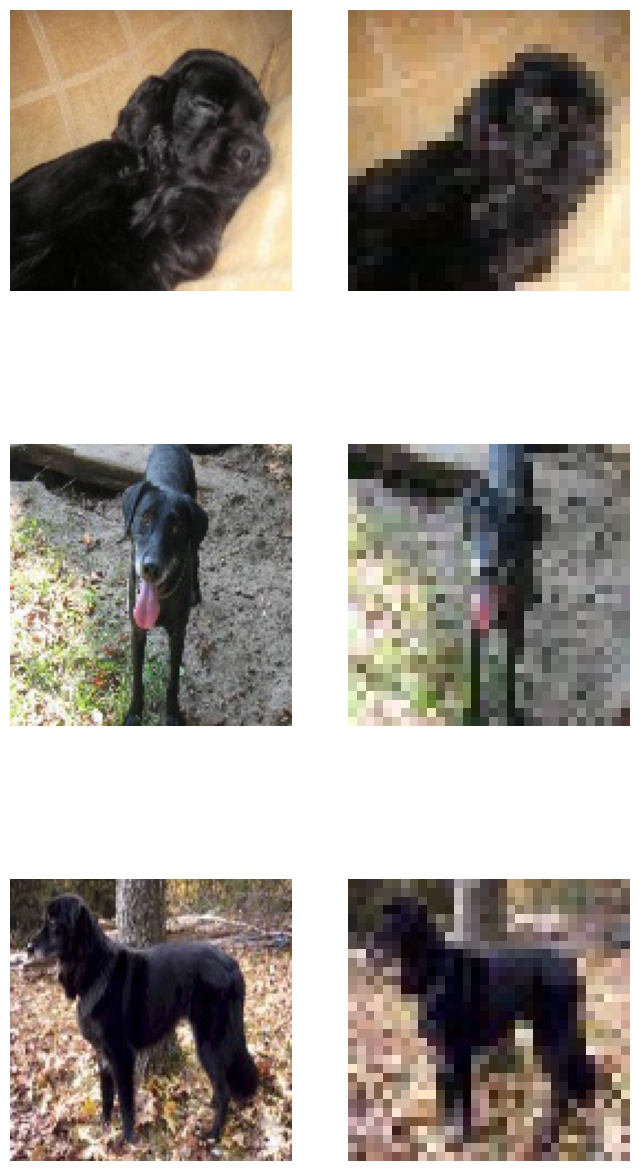

hr_img.shape: (128, 128, 3)
lr_img.shape: (32, 32, 3)


In [21]:


class_name = "dog"  # choose which class to visualize
hr_dir = str(train_dir) + "/hr_images_" + class_name
lr_dir = str(train_dir) + "/lr_images_" + class_name

# get a list of image file names
img_files = os.listdir(hr_dir)


# choose how many images to visualize
num_images = 3

#for random image selection
import random

# Generate three random integers
random_numbers = [random.randint(1, 100) for _ in range(num_images)]

# Print the generated random numbers
print(random_numbers)

j=0

# plot the images
fig, ax = plt.subplots(num_images, 2, figsize=(8, 16))
for i in random_numbers:
# for i in range(num_images):    
    # read the high-resolution image
    hr_img = plt.imread(os.path.join(hr_dir, img_files[i]))
    # read the low-resolution image
    lr_img = plt.imread(os.path.join(lr_dir, img_files[i]))
    # plot the images side by side
    
    ax[j, 0].imshow(hr_img)
    ax[j, 1].imshow(lr_img)
    ax[j, 0].axis("off")
    ax[j, 1].axis("off")
    j=j+1
plt.show()
print('hr_img.shape:', hr_img.shape)
print('lr_img.shape:', lr_img.shape)

In [22]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras import layers, Model
from sklearn.model_selection import train_test_split

import numpy as np
from keras import Model
from keras.layers import Conv2D, PReLU,BatchNormalization, Flatten
from keras.layers import UpSampling2D, LeakyReLU, Dense, Input, add
from tqdm import tqdm

In [23]:
#Define blocks to build the generator
def res_block(ip):
    
    res_model = Conv2D(64, (3,3), padding = "same")(ip)
    res_model = BatchNormalization(momentum = 0.5)(res_model)
    res_model = PReLU(shared_axes = [1,2])(res_model)
    
    res_model = Conv2D(64, (3,3), padding = "same")(res_model)
    res_model = BatchNormalization(momentum = 0.5)(res_model)
    
    return add([ip,res_model])

def upscale_block(ip):
    
    up_model = Conv2D(256, (3,3), padding="same")(ip)
    up_model = UpSampling2D( size = 2 )(up_model)
    up_model = PReLU(shared_axes=[1,2])(up_model)
    
    return up_model

In [24]:
#Generator model
def create_gen(gen_ip, num_res_block):
    layers = Conv2D(64, (9,9), padding="same")(gen_ip)
    layers = PReLU(shared_axes=[1,2])(layers)

    temp = layers

    for i in range(num_res_block):
        layers = res_block(layers)

    layers = Conv2D(64, (3,3), padding="same")(layers)
    layers = BatchNormalization(momentum=0.5)(layers)
    layers = add([layers,temp])

    layers = upscale_block(layers)
    layers = upscale_block(layers)

    op = Conv2D(3, (9,9), padding="same")(layers)

    return Model(inputs=gen_ip, outputs=op)

In [25]:
#Descriminator block that will be used to construct the discriminator
def discriminator_block(ip, filters, strides=1, bn=True):
    
    disc_model = Conv2D(filters, (3,3), strides = strides, padding="same")(ip)
    
    if bn:
        disc_model = BatchNormalization( momentum=0.8 )(disc_model)
    
    disc_model = LeakyReLU( alpha=0.2 )(disc_model)
    
    return disc_model

In [26]:
#Descriminartor, as described in the original paper
def create_disc(disc_ip):

    df = 64
    
    d1 = discriminator_block(disc_ip, df, bn=False)
    d2 = discriminator_block(d1, df, strides=2)
    d3 = discriminator_block(d2, df*2)
    d4 = discriminator_block(d3, df*2, strides=2)
    d5 = discriminator_block(d4, df*4)
    d6 = discriminator_block(d5, df*4, strides=2)
    d7 = discriminator_block(d6, df*8)
    d8 = discriminator_block(d7, df*8, strides=2)
    
    d8_5 = Flatten()(d8)
    d9 = Dense(df*16)(d8_5)
    d10 = LeakyReLU(alpha=0.2)(d9)
    validity = Dense(1, activation='sigmoid')(d10)

    return Model(disc_ip, validity)

In [27]:
from keras.applications import VGG19

def build_vgg(hr_shape):
    
    vgg = VGG19(weights="imagenet",include_top=False, input_shape=hr_shape)
    
    return Model(inputs=vgg.inputs, outputs=vgg.layers[10].output)

In [28]:
#Combined model
def create_comb(gen_model, disc_model, vgg, lr_ip, hr_ip):
    gen_img = gen_model(lr_ip)
    
    gen_features = vgg(gen_img)
    
    disc_model.trainable = False
    validity = disc_model(gen_img)
    
    return Model(inputs=[lr_ip, hr_ip], outputs=[validity, gen_features])

In [42]:
n = 1000

lr_images = []
hr_images = []

for class_name in ["cat", "dog"]:
    lr_list = os.listdir(str(train_dir) + "/lr_images_" + class_name)[:n]
    for img in lr_list:
        img_lr = cv2.imread(str(train_dir) + "/lr_images_" + class_name + "/" + img)
#         img_lr = cv2.cvtColor(img_lr, cv2.COLOR_BGR2RGB)
        lr_images.append(img_lr)   
    
    hr_list = os.listdir(str(train_dir) + "/hr_images_" + class_name)[:n]
    for img in hr_list:
        img_hr = cv2.imread(str(train_dir) + "/hr_images_" + class_name + "/" + img)
#         img_hr = cv2.cvtColor(img_hr, cv2.COLOR_BGR2RGB)
        hr_images.append(img_hr) 

lr_images = np.array(lr_images)
hr_images = np.array(hr_images)

In [69]:
lr_list

['dog.0.jpg',
 'dog.1000.jpg',
 'dog.10000.jpg',
 'dog.10001.jpg',
 'dog.10002.jpg',
 'dog.10003.jpg',
 'dog.10004.jpg',
 'dog.10005.jpg',
 'dog.10006.jpg',
 'dog.10007.jpg',
 'dog.10008.jpg',
 'dog.10009.jpg',
 'dog.1001.jpg',
 'dog.10010.jpg',
 'dog.10011.jpg',
 'dog.10012.jpg',
 'dog.10014.jpg',
 'dog.10015.jpg',
 'dog.10016.jpg',
 'dog.10019.jpg',
 'dog.10020.jpg',
 'dog.10021.jpg',
 'dog.10022.jpg',
 'dog.10023.jpg',
 'dog.10024.jpg',
 'dog.10025.jpg',
 'dog.10026.jpg',
 'dog.10028.jpg',
 'dog.10029.jpg',
 'dog.10030.jpg',
 'dog.10031.jpg',
 'dog.10032.jpg',
 'dog.10034.jpg',
 'dog.10035.jpg',
 'dog.10036.jpg',
 'dog.10037.jpg',
 'dog.10038.jpg',
 'dog.1004.jpg',
 'dog.10042.jpg',
 'dog.10043.jpg',
 'dog.10044.jpg',
 'dog.10045.jpg',
 'dog.10048.jpg',
 'dog.10049.jpg',
 'dog.1005.jpg',
 'dog.10050.jpg',
 'dog.10051.jpg',
 'dog.10055.jpg',
 'dog.10056.jpg',
 'dog.10057.jpg',
 'dog.10058.jpg',
 'dog.10060.jpg',
 'dog.10062.jpg',
 'dog.10063.jpg',
 'dog.10064.jpg',
 'dog.10065.jpg',


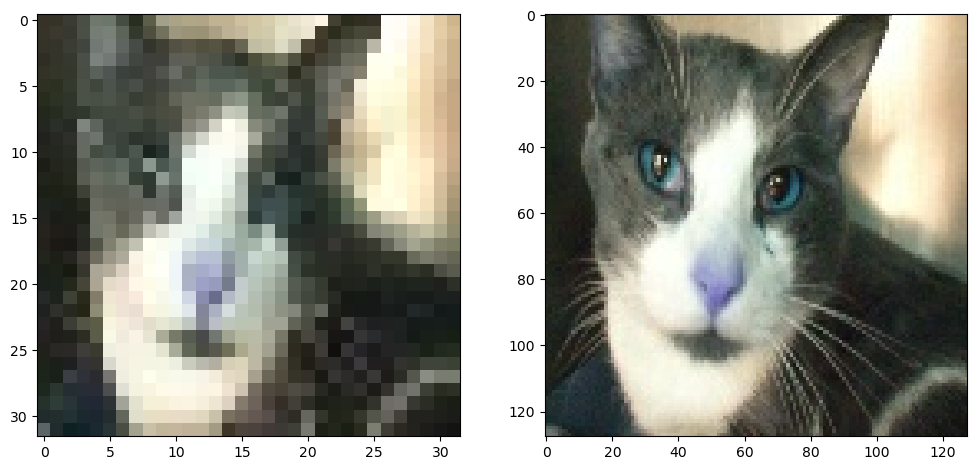

In [44]:
#Sanity check, view few mages
import random
import numpy as np
image_number = random.randint(0, len(lr_images)-1)
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(np.reshape(lr_images[image_number], (32, 32, 3)))
plt.subplot(122)
plt.imshow(np.reshape(hr_images[image_number], (128, 128, 3)))
plt.show()

In [45]:
#Scale values
lr_images = lr_images / 255.
hr_images = hr_images / 255.

In [47]:
#Split to train and test
lr_train, lr_test, hr_train, hr_test = train_test_split(lr_images, hr_images, 
                                                      test_size=0.30, random_state=42)



hr_shape = (hr_train.shape[1], hr_train.shape[2], hr_train.shape[3])
lr_shape = (lr_train.shape[1], lr_train.shape[2], lr_train.shape[3])

lr_ip = Input(shape=lr_shape)
hr_ip = Input(shape=hr_shape)

generator = create_gen(lr_ip, num_res_block = 16)
generator.summary()

discriminator = create_disc(hr_ip)
discriminator.compile(loss="binary_crossentropy", optimizer="adam", metrics=['accuracy'])
discriminator.summary()

vgg = build_vgg((128,128,3))
print(vgg.summary())
vgg.trainable = False

gan_model = create_comb(generator, discriminator, vgg, lr_ip, hr_ip)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 32, 32, 64)           15616     ['input_1[0][0]']             
                                                                                                  
 p_re_lu (PReLU)             (None, 32, 32, 64)           64        ['conv2d[0][0]']              
                                                                                                  
 conv2d_1 (Conv2D)           (None, 32, 32, 64)           36928     ['p_re_lu[0][0]']             
                                                                                              

                                                                                                  
 conv2d_10 (Conv2D)          (None, 32, 32, 64)           36928     ['p_re_lu_5[0][0]']           
                                                                                                  
 batch_normalization_9 (Bat  (None, 32, 32, 64)           256       ['conv2d_10[0][0]']           
 chNormalization)                                                                                 
                                                                                                  
 add_4 (Add)                 (None, 32, 32, 64)           0         ['add_3[0][0]',               
                                                                     'batch_normalization_9[0][0]'
                                                                    ]                             
                                                                                                  
 conv2d_11

 p_re_lu_10 (PReLU)          (None, 32, 32, 64)           64        ['batch_normalization_18[0][0]
                                                                    ']                            
                                                                                                  
 conv2d_20 (Conv2D)          (None, 32, 32, 64)           36928     ['p_re_lu_10[0][0]']          
                                                                                                  
 batch_normalization_19 (Ba  (None, 32, 32, 64)           256       ['conv2d_20[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 add_9 (Add)                 (None, 32, 32, 64)           0         ['add_8[0][0]',               
                                                                     'batch_normalization_19[0][0]
          

 tchNormalization)                                                                                
                                                                                                  
 p_re_lu_15 (PReLU)          (None, 32, 32, 64)           64        ['batch_normalization_28[0][0]
                                                                    ']                            
                                                                                                  
 conv2d_30 (Conv2D)          (None, 32, 32, 64)           36928     ['p_re_lu_15[0][0]']          
                                                                                                  
 batch_normalization_29 (Ba  (None, 32, 32, 64)           256       ['conv2d_30[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 add_14 (A

                                                                 
 conv2d_42 (Conv2D)          (None, 16, 16, 256)       590080    
                                                                 
 batch_normalization_37 (Ba  (None, 16, 16, 256)       1024      
 tchNormalization)                                               
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 16, 16, 256)       0         
                                                                 
 conv2d_43 (Conv2D)          (None, 16, 16, 512)       1180160   
                                                                 
 batch_normalization_38 (Ba  (None, 16, 16, 512)       2048      
 tchNormalization)                                               
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 16, 16, 512)       0         
                                                                 
 conv2d_44

In [48]:
# 2 losses... adversarial loss and content (VGG) loss
#AdversariaL: is defined based on the probabilities of the discriminator over all training samples
# use binary_crossentropy

#Content: feature map obtained by the j-th convolution (after activation) 
#before the i-th maxpooling layer within the VGG19 network.
# MSE between the feature representations of a reconstructed image
# and the reference image. 
gan_model.compile(loss=["binary_crossentropy", "mse"], loss_weights=[1e-3, 1], optimizer="adam")
gan_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 model (Functional)          (None, 128, 128, 3)          2044291   ['input_1[0][0]']             
                                                                                                  
 input_2 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 model_1 (Functional)        (None, 1)                    3824928   ['model[0][0]']               
                                                          1                                 

In [49]:
#Create a list of images for LR and HR in batches from which a batch of images
#would be fetched during training. 
batch_size = 1  
train_lr_batches = []
train_hr_batches = []
for it in range(int(hr_train.shape[0] / batch_size)):
    start_idx = it * batch_size
    end_idx = start_idx + batch_size
    train_hr_batches.append(hr_train[start_idx:end_idx])
    train_lr_batches.append(lr_train[start_idx:end_idx])

In [50]:
epochs = 150
#Enumerate training over epochs
for e in range(epochs):
    
    fake_label = np.zeros((batch_size, 1)) # Assign a label of 0 to all fake (generated images)
    real_label = np.ones((batch_size,1)) # Assign a label of 1 to all real images.
    
    #Create empty lists to populate gen and disc losses. 
    g_losses = []
    d_losses = []

In [51]:
#Enumerate training over batches. 
for b in tqdm(range(len(train_hr_batches))):
        lr_imgs = train_lr_batches[b] #Fetch a batch of LR images for training
        hr_imgs = train_hr_batches[b] #Fetch a batch of HR images for training

100%|██████████| 1400/1400 [00:00<?, ?it/s]


In [52]:
fake_imgs = generator.predict_on_batch(lr_imgs) #Fake images

In [53]:
#First, train the discriminator on fake and real HR images. 
discriminator.trainable = True
d_loss_gen = discriminator.train_on_batch(fake_imgs, fake_label)
d_loss_real = discriminator.train_on_batch(hr_imgs, real_label)

In [54]:
#Now, train the generator by fixing discriminator as non-trainable
discriminator.trainable = False

In [55]:
#Average the discriminator loss, just for reporting purposes. 
d_loss = 0.5 * np.add(d_loss_gen, d_loss_real) 

In [56]:
#Extract VGG features, to be used towards calculating loss
image_features = vgg.predict(hr_imgs)

1/1 [==============================] - 0s 72ms/step


In [57]:
#Train the generator via GAN. 
#we have 2 losses, adversarial loss and content (VGG) loss
g_loss, _, _ = gan_model.train_on_batch([lr_imgs, hr_imgs], [real_label, image_features])

In [58]:
#Save losses to a list so we can average and report. 
d_losses.append(d_loss)
g_losses.append(g_loss)

In [59]:
#Convert the list of losses to an array to make it easy to average    
g_losses = np.array(g_losses)
d_losses = np.array(d_losses)

In [60]:
#Report the progress during training. 
print("epoch:", e+1 ,"g_loss:", g_loss, "d_loss:", d_loss)

if (e+1) % 10 == 0: #Change the frequency for model saving, if needed
        #Save the generator after every n epochs (Usually 10 epochs)
        generator.save("gen_e_"+ str(e+1) +".h5")

epoch: 150 g_loss: 296.1236877441406 d_loss: [7.68348399 0.        ]


C:\Users\Rashadul Hasan Badho\miniconda3\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [61]:
#Test - perform super resolution using saved generator model
from keras.models import load_model
from numpy.random import randint

In [62]:
generator = load_model('gen_e_150.h5', compile=False)

In [63]:
import os
import cv2
import numpy as np

def load_data(directory):
  images = []
  labels = []
  classes = sorted(os.listdir(directory))
  for i, class_name in enumerate(classes):
    class_dir = os.path.join(directory, class_name)
    for image_file in os.listdir(class_dir):
      image_path = os.path.join(class_dir, image_file)
      image = cv2.imread(image_path)
      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
      images.append(image)
      labels.append(i)
      return np.array(images), np.array(labels)

In [64]:
test_images, test_labels = load_data(val_dir)

In [66]:
[X1, X2] = [lr_test, hr_test]
# select random example
ix = randint(0, len(X1), 1)
src_image, tar_image = X1[ix], X2[ix]

In [67]:
# generate image from source
gen_image = generator.predict(src_image)

1/1 [==============================] - 0s 427ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


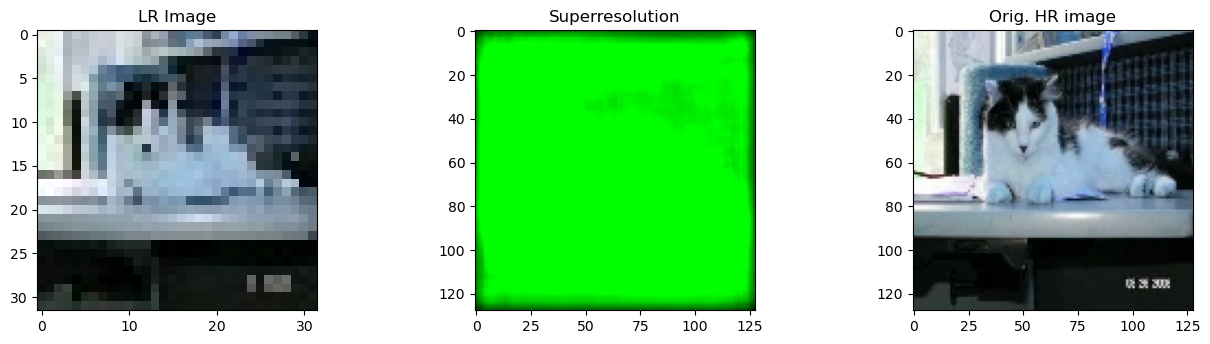

In [68]:
# plot all three images

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('LR Image')
plt.imshow(src_image[0,:,:,:])
plt.subplot(232)
plt.title('Superresolution')
plt.imshow(gen_image[0,:,:,:])
plt.subplot(233)
plt.title('Orig. HR image')
plt.imshow(tar_image[0,:,:,:])
plt.show()

In [81]:
lr_images_cat = cv2.imread("D:/UNCC/Fall_23/ECGR_8119/hw_1/dogs_vs_cats/splitdata_midterm/train/lr_images_cat/cat.0.jpg")
hr_images_cat = cv2.imread("D:/UNCC/Fall_23/ECGR_8119/hw_1/dogs_vs_cats/splitdata_midterm/train/hr_images_cat/cat.0.jpg")
lr_images_dog = cv2.imread("D:/UNCC/Fall_23/ECGR_8119/hw_1/dogs_vs_cats/splitdata_midterm/train/lr_images_dog/dog.0.jpg")
hr_images_dog = cv2.imread("D:/UNCC/Fall_23/ECGR_8119/hw_1/dogs_vs_cats/splitdata_midterm/train/hr_images_dog/dog.0.jpg")

In [82]:
lr_images_cat = lr_images_cat / 255.
hr_images_cat = hr_images_cat / 255.
lr_images_dog = lr_images_dog / 255.
hr_images_dog = hr_images_dog / 255.

In [83]:
lr_images_cat = np.expand_dims(lr_images_cat, axis=0)
hr_images_cat = np.expand_dims(hr_images_cat, axis=0)
lr_images_dog = np.expand_dims(lr_images_dog, axis=0)
hr_images_dog = np.expand_dims(hr_images_dog, axis=0)

In [84]:
generated_lr_images_cat = generator.predict(lr_images_cat)
generated_hr_images_cat = generator.predict(hr_images_cat)

1/1 [==============================] - 1s 1s/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


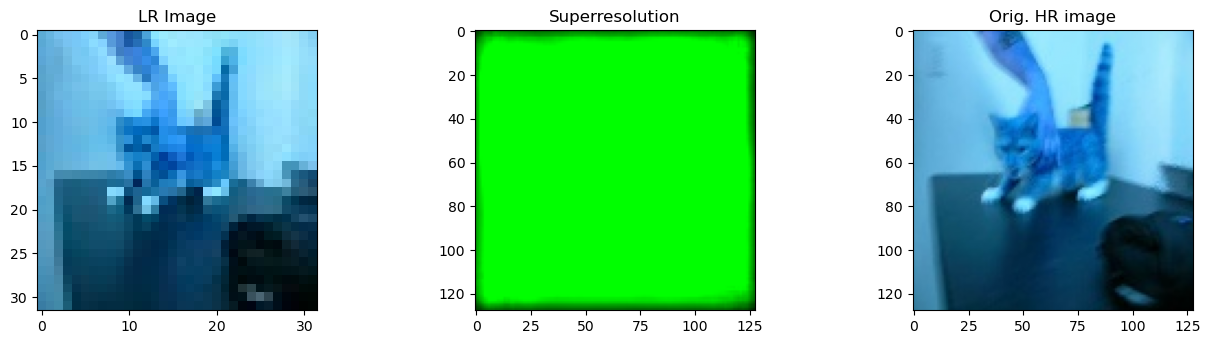

In [86]:
# plot all three images
plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('LR Image')
plt.imshow(lr_images_cat[0,:,:,:])
plt.subplot(232)
plt.title('Superresolution')
plt.imshow(generated_lr_images_cat[0,:,:,:])
plt.subplot(233)
plt.title('Orig. HR image')
plt.imshow(hr_images_cat[0,:,:,:])

plt.show()